Computer Vision
---------------------------------------------------------------

This notebook will delve into some deep learning applications for computer vision.

---------------------------------------------------------------

# 1. Overview
This notbeook consists of *three main parts*:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In this notebook, I will train an end-to-end neural network for image classification, followed by a similar approach for semantic segmentation. For both tasks, I will focus on optimizing performance and competing with fellow students through a Kaggle competition.  

Beyond model training, I will analyze the weaknesses of my classification and/or segmentation networks, aiming to find and exploit their vulnerabilities. Unlike the competition-driven sections, this part will be more self-directed, where I will define my own goals and strive for meaningful insights.  

Finally, I will reflect on my findings and provide an overall discussion, linking my work to the course lectures and real-world computer vision applications.

## 1.1 Deep learning resources
The TensorFlow and/or Keras library is used for building deep learning models. Nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.transform import resize
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests
import torch
from torch import nn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping

import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## 1.2 PASCAL VOC 2009
For this project I will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [ ]:
# Show some examples
def plot_images(train_df, labels):
    fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
    for i, label in enumerate(labels):
        df = train_df.loc[train_df[label] == 1]
        axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
        axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
        axs[0, i].axis("off")
        axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
        axs[1, i].axis("off")

    plt.show()

In [ ]:
# Loading the training data
train_df = pd.read_csv('//kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

#plot_images(train_df, labels)

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> the task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

## 1.3 Your Kaggle submission
The filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded).

In [ ]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    transforms and writes the test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

## 1.4 Image Augmentation

Adding augmented data is a common technique to increase the amount of training data available. This is done by reducing overfitting on training data, therefore increasing the robustness of the trained model.

In [ ]:
def add_gaussian_noise(image,p=0.5, mean=0, std=25):
    if random.uniform(0, 1) > p:
        return image
    """Add Gaussian noise to an image."""
    row, col, ch = image.shape
    gauss = np.random.normal(mean, std, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255)
    return noisy_image.astype(np.uint8)

def random_erasing(image, p=0.75, sl=0.02, sh=0.4, r1=0.3, r2=3):
    if random.uniform(0, 1) > p:
        return image

    img_h, img_w, _ = image.shape
    area = img_h * img_w

    while True:
        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, r2)
        w = int(np.sqrt(target_area * aspect_ratio))
        h = int(np.sqrt(target_area / aspect_ratio))
        left = random.randint(0, img_w)
        top = random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            erased_image = np.copy(image)
            erased_image[top:top + h, left:left + w, :] = np.random.rand(h, w, 3) * 255
            return erased_image
        
def horizontal_flip(image,p=0.25):
    if random.uniform(0, 1) > p:
        return image
    return np.fliplr(image)

def adjust_brightness(image, probability=1, brightness_range=(0.7, 1.3), contrast_range=(0.7, 1.3)):
    if random.uniform(0, 1) > probability:
        return image
    brightness_factor = random.uniform(*brightness_range)
    contrast_factor = random.uniform(*contrast_range)
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=brightness_factor)

    return adjusted_image

def random_augmentations(image,p=0.25):
    image = add_gaussian_noise(image)
    image = random_erasing(image)
    image = horizontal_flip(image)
    image = adjust_brightness(image)
    return image

In [ ]:
import numpy as np
import pandas as pd
import random
import cv2 # OpenCV package
import gc

def generate_augmented_data(train_df):
    augmented_data = []

    for i, row in train_df.iterrows():
        img = row['img']
        labels = row[:20].values 

        img = cv2.resize(img, (224, 224))

        for _ in range(2):
            aug = random_augmentations(img, p=1)
            aug = cv2.resize(aug, (224, 224))

            # Create a new row with the augmented image and the same labels
            new_row = pd.Series(list(labels) + [aug] + [-1], index=row.index)

            # Append the new row to the list
            augmented_data.append(new_row)

    # Convert the list to a DataFrame
    augmented_df = pd.DataFrame(augmented_data)

    return augmented_df

## 1.5 Notebook overview and information

The notebook is divided into 4 main parts with each part containing different subsections:


- **Image classification** : developed two image classifiers from scratch (a CNN and a ViT) and fine-tuned two pre-trained networks (DETR and Google's ViT). After evaluating their performance (Validating the model on a test sample visually, monitoring loss scores, gaining information from a confusion matrix), the best-performing model is selected for submission.
- **Semantic segmentation** : made one model from scratch (U-net) and 2 pre-trained models (PSPnet and DETR). After evaluating their performance (Vissually comparing the predected mask with the ground truth, monitoring loss scores, parameter finetuning), selected the best-performing model for submission.
- **Adversarial attack** : applied the FGSM (Fast gradient sign method) attack to perbuate an image with noise to trick the model into wrongfully classyfing an image.
- **Discussion** : summerized the findings.

---NOTE---

Some code blocks are commented out to save on running time but are kept in the notebook with their output to show the findings when testing out these networks.


# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

**Image Classification**

The problem involves developing an image classification system capable of accurately identifying and classifying multiple objects present in a single image. This requires recognizing the presence of various objects and assigning correct labels to each one. This is a sub-problem of classification, called multi-label classification. 

### 2.0 Preproccesing : resize image

Since the training and testing images have varying shapes, and models typically require consistent input dimensions, all the images must be resized to the appropriate shape before feeding them into the model.

In [ ]:
def resize_images(images,img_size):
    list_images = list()
    for img in images:
        img_resized = resize(img,img_size)
        list_images.append(img_resized)
    return np.array(list_images) 

In [ ]:
input_shape = (150,150,3)

X_train = resize_images(train_df["img"],input_shape)
X_test = resize_images(test_df["img"],input_shape)

num_classes = 20

print(f"x_train shape: {X_train.shape} - X_test shape: {X_test.shape}")


In [ ]:
# Show some examples
def plot_images_train(images):
    
    fig, axs = plt.subplots(1, 10, figsize=(50, 50))
    for i, image in enumerate(images[:10]):
        axs[i].imshow(image, vmin=0, vmax=255)
        axs[i].axis("off")

    plt.show()

Now, let's plot the appearance of the resized test and train images.

In [ ]:
plot_images_train(X_train)

In [ ]:
plot_images_train(X_test)

# 2.1 Models from scratch

The following code produces 2 arrays :
* **y_train** : the encoding that the model has to predict where each index corresponds with an label.
* **label_map** : a map where each element at an index represents the label. 

In [ ]:
train_df.columns[:20]

In [ ]:
# Store training set labels
y_train = []
label_map = train_df.columns[:20]
for i in range(train_df['img'].shape[0]):
    img = train_df['img'][i]
    temp = list()
    for i in train_df.loc[i][:20]:
        temp.append(i)
    y_train.append(np.array(temp))     
y_train = np.array(y_train)
print("Labels of the training images:",np.array(y_train).shape)

## 2.1.1 CNN from scratch 

A **Convolutional Neural Network (CNN)** is a regularized type of feed-forward neural network designed that is able  to autonomously learn feature representation through optimized filters (or kernels). CNNs are strong in processing grid-like data, such as images, due to their ability to capture spatial hierarchies of features through convolution and pooling operations. This hierarchical feature learning allows CNNs to extract meaningful patterns and representations from the input data, making them effective for tasks like image classification.

The code below defines the sequential (linear stack of layers) model. The class Sequential takes an array of layers. inspiration of AlexNet architecture is used to build this CNN model but it is modified to perform better on this case. Modifications: changing some layer parameters or removing dense layers.

```python

# Architecture of the CNN

model = Sequential([
    Input(shape=(input_shape)),
    Convolution2D(filters=96, kernel_size=(7, 7), strides=4,activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Convolution2D(256, kernel_size=(5,5), strides= 1, padding= 'same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Convolution2D(filters=384, kernel_size=(3, 3),activation='relu', padding='same'),
    Convolution2D(filters=384, kernel_size=(3, 3),activation='relu', padding='same'),
    Convolution2D(filters=256, kernel_size=(3, 3),activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    Flatten(), 
    #Dense(1000, activation= 'relu'),
    Dense(128,activation='relu'),
    Dense(num_classes,activation = 'softmax')
])
```

# Convolutional Neural Network (CNN) Architecture  

1. **Input layer**  
Defines the size of the input images.  

2. **5 Convolutional layers**  
In these layers, filters (kernels) are learned and slide along input features to detect and extract meaningful patterns. The image is transformed into a feature map, where details are abstracted and represented more compactly. Different kernel sizes and filter counts are used in each convolutional layer, inspired by the AlexNet architecture.  

3. **Pooling layers**  
Following the convolutional layers, max pooling is applied to reduce the dimensionality of the feature maps while preserving the most important features. A max pooling layer with a (3,3) kernel and (2,2) stride is used. These layers scan a 3x3 grid of the input, selecting the maximum value before moving the grid by 2 pixels to repeat the process across the rest of the feature map.  

4. **Flatten layer**  
This step converts the 2D feature maps into a 1D array, making them suitable for input into fully connected layers.  

5. **1 Dense or fully connected layer**  
Acts as the classifier, mapping extracted features to their corresponding labels using a structure similar to a traditional multilayer perceptron (MLP).  

6. **Dense output layer**  
Produces the final prediction by applying the softmax activation function, yielding a probability distribution over all possible classes. The size of this layer corresponds to the number of classification labels.  


## **Training the Model**  

With the model architecture defined, training begins on the PASCAL VOC 2009 dataset. Training a neural network requires specifying certain hyperparameters, which control aspects of the learning process such as the optimizer and loss function. The following hyperparameters were used:  

* **Loss = binary_crossentropy**  
  This loss function is ideal for multi-label classification tasks, where each label is treated independently as a binary classification problem (belonging to the class or not). This makes it well-suited for the multi-label classification problem at hand.  

* **Optimizer = adam**  
  Adam ("Adaptive Moment Estimation") is an optimization algorithm that extends stochastic gradient descent (SGD) by adapting learning rates for each parameter dynamically.  

* **Metric = categorical_accuracy**  
  Since the model produces class probabilities using a softmax activation function, categorical accuracy is used to measure performance. It evaluates whether the predicted class (i.e., the one with the highest probability) matches the correct label.  

* **EarlyStopping = 50**  
  To prevent overfitting, early stopping monitors validation accuracy. If no improvement is seen for 50 consecutive epochs, training is halted.  

* **Batch size = 128**  
  Different batch sizes were tested, and 128 provided the best performance.  


```python
# Configuration of learning process
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy']) 
early_stopping_monitor = EarlyStopping(patience = 50)
```

```python
training_results = model.fit(X_train, y_train, validation_split = 0.25, epochs=150, batch_size=128, callbacks= [early_stopping_monitor]) 
```

### **Evaluation of the CNN Model**  

Examining the categorical accuracy, the training accuracy continues to increase, but validation accuracy shows only slight improvement. This suggests that the model is likely starting to overfit on the training data, reducing its ability to generalize effectively to new data.  

Overall, the model trained from scratch appears to be underperforming. This is further evident in the test sample prediction below, where the model struggles to correctly identify a clearly visible bicycle.  


```python
plt.plot(training_results.history['categorical_accuracy'],'r') 
plt.plot(training_results.history['val_categorical_accuracy'],'b') 
plt.figsize=(12,6)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'])
```

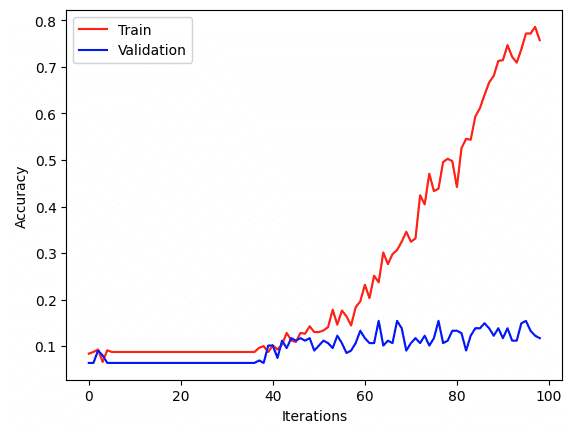

#### Testing the model on a test sample

```python
pred = model.predict(np.array([X_test[3]]))
plt.imshow(X_test[3])
plt.axis("off")
plt.title('Trained model predicted : "' + str(label_map[pred[0].argmax()]) + '" for the following test sample')
```

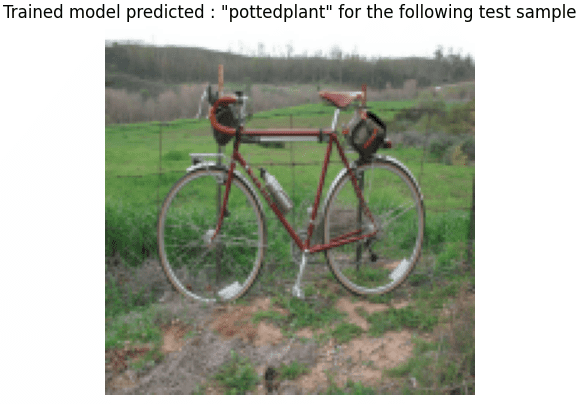

## 2.1.2 ViT (Visual Transformer) from scratch
A **vision transformer (ViT)** is a transformer designed for computer vision. Transformers are extremely good in the domain of NLP but the paper "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE" by Alexey Dosovitskiy has found use for it in the domain of computer vision. A ViT breaks down an input image into a series of patches (rather than breaking up text into tokens), serialises each patch into a vector, and maps it to a smaller dimension with a single matrix multiplication. These vector embeddings are then processed by a transformer encoder as if they were token embeddings. 
While CNNs are state-of-the-art in computer vision, the paper showed that ViT can be competitive with (or even better than) state-of-the-art CNNs. ViT has found applications in image recognition.

As previously mentioned, ViT is a modified transformer specifically designed for processing images. While a detailed discussion of transformers is beyond the scope of this, a brief summary is provided. A transformer efficiently processes sequential data using self-attention to focus on important elements and feedforward networks to capture long-range dependencies.  

The image below illustrates the model's architecture. Input images are divided into equal-sized patches, which are then transformed into 1D vectors. Since the transformer maintains a constant latent vector size \( D \) across its layers, these vectors are mapped to a \( D \)-dimensional space using a trainable linear projection. Additionally, positional information is embedded into the transformed patches to indicate their spatial location within the image. A learnable embedding is also added at position 0 of the sequence, which is essential for classification.  

After passing through the transformer, the output is fed into a Multi-Layer Perceptron (MLP) to predict the probability of each class.  

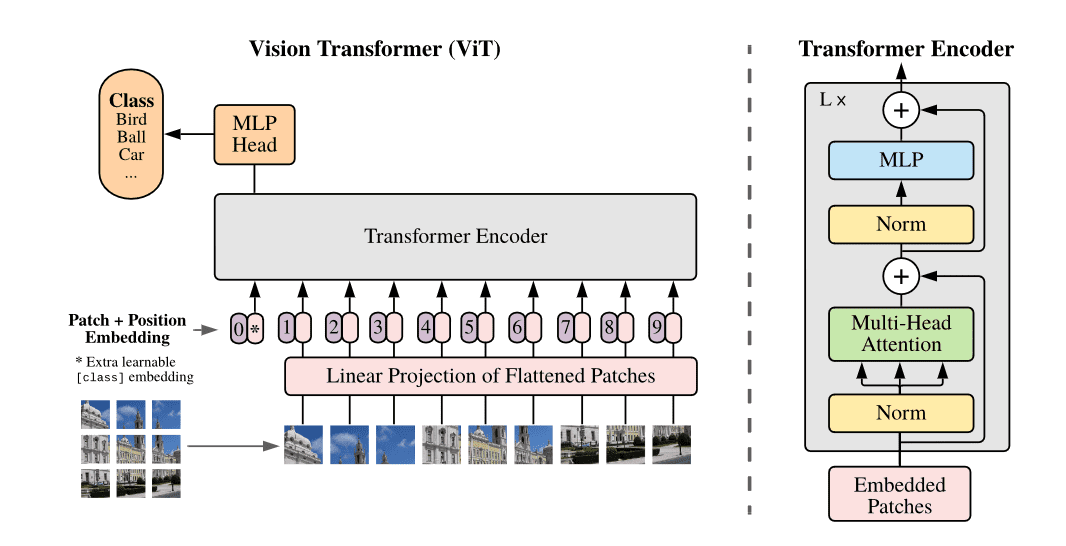  


Due to the model's complexity, several parameters must be configured to influence both the learning process and the architecture. The most important ones are highlighted below:  

* **image_size**  
  Images are resized to a shape of (image_size, image_size) before being processed.  

* **patch_size**  
  Defines the size of each patch. This value must be a divisor of image_size to ensure the image is evenly divided into patches.  

* **projection_dim**  
  Specifies the dimension of the latent vector. In transformers, this parameter affects the model’s capacity and ability to encode information.  

Other parameters are specific to the transformer architecture or the learning process and will not be discussed here.  


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

The first layer is the **data_augmentation** layer. The responsibility of this layer is to resizes the images to the constant input size for the model. It also does some random augmentation like flipping or rotating the input to make the model more robust.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:
# function to easily add mlp layers
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

The transformation steps discussed earlier are implemented as a layer within the model. The code below defines two classes to handle these transformations:  

* **Patches**  
  Divides the input image into smaller patches.  

* **PatchEncoder**  
  Projects the patches into the correct dimension and encodes their positional information.  


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

The **Patches** layer can be called independently of the model, allowing for direct visualization of its output. This feature provides insight into how the image is divided into patches.  


In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

The function below constructs a Vision Transformer (ViT) classifier. While different parameters can modify specific aspects of the model, the overall architecture remains the same:  
1. **Input layer**
2. **Augmentation layer**
3. **Patching layer**
4. **Patch encoding layer**
5. **Transform layer** (consisting of different transform layers)
6. **MLP layers**
7. **Output layer** using softmax activation function

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation = 'softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=['categorical_accuracy']
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    return history


# vit_classifier = create_vit_classifier()
# history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


# plot_history("loss")
# plot_history("categorical_accuracy")

### **Evaluation of the ViT Model**  

Examining the categorical accuracy, the training accuracy continues to increase, but validation accuracy shows little to no improvement. This suggests that the model is likely starting to overfit on the training data, limiting its ability to generalize effectively.  

ViTs often struggle with small datasets. The state-of-the-art results reported in the paper *"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"* were achieved by pre-training the ViT model on the JFT-300M dataset, followed by fine-tuning on the target dataset. Later in this notebook, a pre-trained ViT model will be explored.  

Overall, the model trained from scratch appears to be underperforming. This is further evident in the test sample prediction below, where the image clearly depicts a bicycle, yet the model incorrectly predicts "person."  


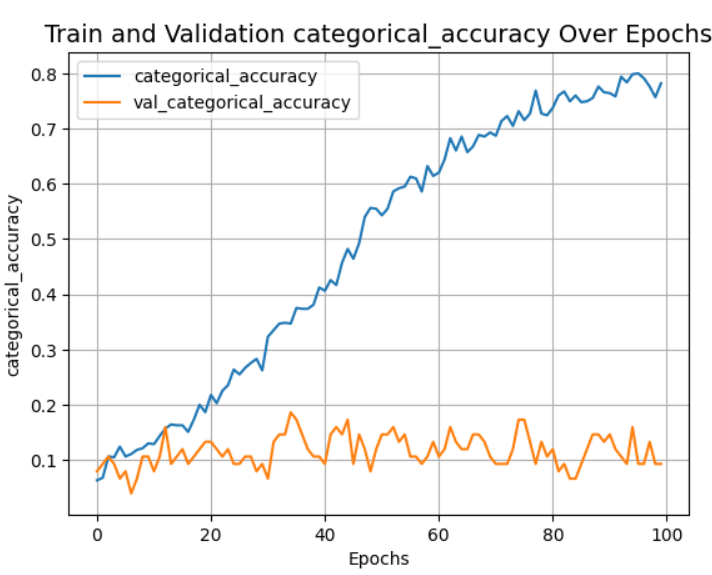

#### Testing the model on a test sample

```python
res = vit_classifier.predict(np.array([X_test[3]]))
```

```python
plt.imshow(X_test[3])
plt.axis("off")
plt.title('Trained model predicted : "' + str(label_map[res[0].argmax()]) + '" for the following test sample')
```

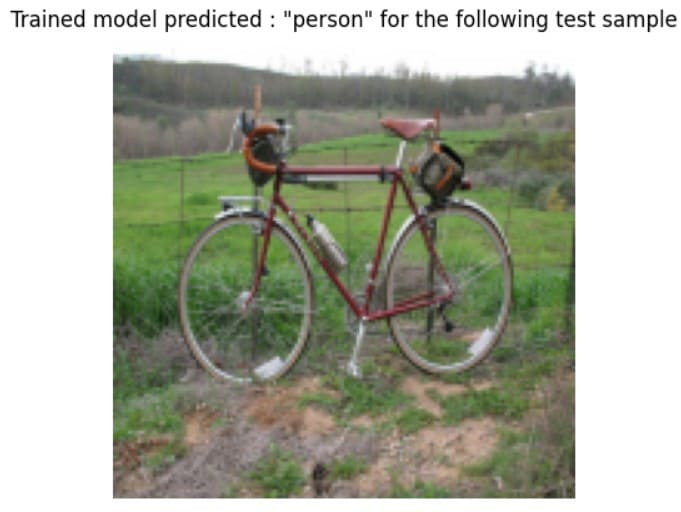

### **Conclusion**  

Training a model from scratch is challenging, especially when the training dataset is relatively small. Both models trained from scratch exhibited overfitting, failing to generalize effectively to the task. Fine-tuning parameters led to only minor improvements in training accuracy.  

The results clearly indicate that a pre-trained model is necessary to achieve more accurate predictions.  


# 2.2 Pretrained model

Training a model from scratch might not always be the best option, especially when there isn't a lot of training data. A solution to this problem is to use a pre-trained model. These models already had their weights trained on huge datasets and can be easily fine-tuned on our own dataset.

## 2.2.1 DETR

DETR models use transformers to do end-to-end image detection. More specifically, they use an encoder-decoder transformer on top of a convolutional backbone. For the image detection, object queries are used. These models were first introduced in the paper "End-to-End Object Detection with Transformers" from N. Carion et al.

This model has been shown to work well for the object detection task. The one used in the following example is developed by Facebook and can be found here: https://huggingface.co/facebook/detr-resnet-50.

This model is trained on the COCO 2017 object detection dataset. Interestingly for this example, the output lables of this model contained all the labels for our dataset. Therefore, this model can be used for object detection in our data without the need to adapt or fine-tune the model. This model will explore the performance out of the box, later a fine-tuned model will also be highlighted.

Examples like these highlight the power of these pre-trained models, given that you can find a similar dataset to your own, these models can be almost plug-and-play.

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
from time import time
import pandas as pd
import numpy as np

# A function to get and run the detr model on a given dataframe
def run_pre_trained_detr_model(input_df):
    # Initialize the pre-trained model and processor
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

    # Add GPU support to speed up computations
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    one_hot_lst = []
    start = time()

    # Iteratively give the images to the model and get the predictions
    torch.cuda.empty_cache()
    for i in range(len(input_df)):
        # Extract and convert the np_array from the test_df to an image
        image = Image.fromarray(input_df["img"][i])
        # Feed the image to the model and predict the classes
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        # Threshold the prediction to 0.9, we only want classes with high confidence
        results = processor.post_process_object_detection(outputs, 
                                                          target_sizes=target_sizes, 
                                                          threshold=0.9)[0]

        one_hot_row = pd.Series(np.zeros(len(labels)), index=labels)

        # get the lable from the prediction
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            detected_label = model.config.id2label[label.item()]

            # Some of the lables had different names
            if detected_label == "airplane":
                detected_label = "aeroplane"
            if detected_label == "dining table":
                detected_label = "diningtable"
            if detected_label == "motorcycle":
                detected_label = "motorbike"
            if detected_label == "potted plant":
                detected_label = "pottedplant"
            if detected_label == "couch":
                detected_label = "sofa"
            if detected_label == "tv":
                detected_label = "tvmonitor"

            if detected_label in labels:
                one_hot_row[detected_label] = 1

        # Append the one-hot encoded row to the dataframe
        #print(one_hot_row)
        one_hot_lst.append(one_hot_row)
    end = time()
    print(f'took: {(end - start)/60} minutes')
    return one_hot_lst

torch.cuda.empty_cache()

# Get the predictions from the detr model and convert it to a DataFrame
detr_predict = run_pre_trained_detr_model(test_df)
detr_predict_df = pd.DataFrame(detr_predict, columns=labels)
detr_predict_df['img'] = test_df['img']
#print(one_hot_df)


The previous code block demonstrates how to classify images from `train_df` and create a new dataframe, **detr_predict_df**, containing the predicted labels.  

Since the training data is not used to build the model, it provides an ideal dataset with labeled images to evaluate the model's performance. The following code block calculates the percentage of matching labels between the predictions and the original training data.  


In [ ]:
#As the model wasn't trained on the same data, labled training data could be used to validate the performance
detr_predict_train = run_pre_trained_detr_model(train_df)
detr_predict_df_train = pd.DataFrame(detr_predict_train, columns=labels)
subset_train_df = train_df.iloc[:749, :20]

# Compare the DataFrames
comparison_df = detr_predict_df_train.eq(subset_train_df)
# Calculate the percentage of matching labels
percentage_matching = (comparison_df.sum().sum() / comparison_df.size) * 100

print(f"The percentage of matching labels is {percentage_matching}%")


```python
```
took: 1.515708065032959 minutes

The percentage of matching labels is 98.36448598130842%

#### Testing the model on a test sample

```python
plt.imshow(X_test[3])
plt.axis("off")
plt.title('Trained model predicted : "' + str(label_map[detr_predict[3].argmax()]) + '" for the following test sample')
```

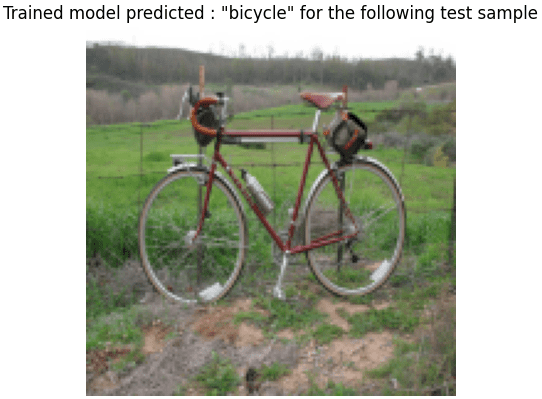

### Prediction performance summary

The bar chart below demonstrates the model's impressive accuracy on the training data, correctly classifying most image classes. Although there are instances where the model fails to detect an object, as indicated by the red bars, these errors are relatively infrequent compared to its successful detections. Additionally, the chart shows that the model occasionally identifies too many objects in an image, detecting objects that are not actually present.

In [ ]:
preds = []
for pred_instace in detr_predict_train:
    pred_classes = []
    for col_index, col_value in enumerate(pred_instace):
        if col_value == 1:
            pred_classes.append(col_index)
    preds.append(pred_classes)

y_true = []
for outcome in y_train:
    classes = []
    for col_index, col_value in enumerate(outcome):
        if col_value == 1:
            classes.append(col_index)
    y_true.append(classes)
    
flat_preds = []
flat_true = []
all_missed = []
all_to_much = []
# classes_pred and classes_true are sorted
for classes_pred, classes_true in zip(preds, y_true):
        # Convert lists to sets for set operations
        set_search = set(classes_true)
        set_found = set(classes_pred)

        # Elements in array_search but not in array_found
        missed = list(set_search - set_found)

        # Elements in array_found but not in array_search
        to_much = list(set_found - set_search)

        # Elements in both array_search and array_found
        overlapping = list(set_search & set_found)

        # Print results
        all_missed = all_missed + missed
        all_to_much = all_to_much + to_much
        for i in overlapping:
            flat_preds.append(i)
            flat_true.append(i)


In [ ]:
from collections import Counter

def count_occurrences(array):
    return dict(Counter(array))

def to_class_name(array):
    class_names = []
    for name_indx in array:
        class_names.append(label_map[name_indx])
    return class_names

def match_keys(map1, map2):
    for key in map1:
        if key not in map2:
            map2[key] = 0
    return map2

In [ ]:
occurrences_correct = count_occurrences(to_class_name(flat_preds))

occurrences_missed = match_keys(occurrences_correct, count_occurrences(to_class_name(all_missed)))

occurrences_to_much = match_keys(occurrences_correct, count_occurrences(to_class_name(all_to_much)))

print("Amount of correctly detected objects")
print(occurrences_correct)
print()
print("True labels that were not predicted")
print(occurrences_missed)
print()
print("Predicted classes that are not in images ")
print(occurrences_to_much)

In [ ]:
# importing package
import matplotlib.pyplot as plt


sorted_correct = dict(sorted(occurrences_correct.items(),key=lambda x:x[0]))
sorted_missed = dict(sorted(occurrences_missed.items(),key=lambda x:x[0]))
sorted_to_much = dict(sorted(occurrences_to_much.items(),key=lambda x:x[0]))


# create data
x = list(sorted_correct.keys())
correct = np.array(list(sorted_correct.values()))
missed = np.array(list(sorted_missed.values()))
to_much = np.array(list(sorted_to_much.values()))
 
fig, ax = plt.subplots()

# plot bars in stack manner
ax.bar(x, correct, color='g')
ax.bar(x, missed, bottom=correct, color='r')
ax.bar(x, to_much, bottom=correct + missed, color='b')

ax.set_xlabel('Classes')
ax.set_ylabel('Amount')
ax.set_title('Performance chart')
ax.tick_params(axis='x', rotation=75)

colors = {'Correct':'green', 'Missed':'red', 'To much' : 'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

plt.show()

## **2.2.2 Vision Transformer (ViT)**  

The pre-trained model used in this section is a Vision Transformer (ViT), as previously discussed. Instead of building a model from scratch, this ViT model has already been pre-trained on the ImageNet-21k dataset (14 million images, 21,843 classes) at a resolution of 224×224 and further fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at the same resolution. The model is available at: [Hugging Face - ViT Base Patch16 224](https://huggingface.co/google/vit-base-patch16-224).  

Unlike the previous pre-trained model, this one will be fine-tuned on the dataset. The final layer will be modified to predict only the required labels, making it a more practical approach when a pre-trained model cannot predict all target labels or when sufficient data is available for fine-tuning.  


```python
from transformers import ViTFeatureExtractor

# Load the model and initialize the processor
# The processor will be used to prepare the data for the model
model_id = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
```

```python
from datasets import Dataset

# Helper function to process the data for the pre-trained model
def process(batch):
    # Take a list of images and turn them into pixel values
    inputs = processor([x for x in batch['img']], return_tensors='pt')
    
    # Add the tables
    inputs['labels'] = batch[labels]
    return inputs
```

```python
from huggingface_hub import HfFolder
import tensorflow as tf

train_batch_size = 32
val_batch_size = 32
```

```python
# Add augmented data, this is a good way to make the model more robust
augmented_df = generate_augmented_data(train_df)
```

Construct a dataset with a validation split for testing the performance of the pre-trained model. A validation set will reduce the overall training data, but gives us important insight to the performance while the model is training. This can be used to fine tune hyper parameters.

```python
from transformers import DefaultDataCollator
from sklearn.model_selection import train_test_split

# Process the dataframes
processed_df_train = process(augmented_df)

# Convert the processed data to tensors
pixel_values_train = tf.convert_to_tensor(processed_df_train['pixel_values'])
labels_train = tf.convert_to_tensor(processed_df_train['labels'])

# Convert the tensors back to numpy arrays for the split
pixel_values_np = pixel_values_train.numpy()
labels_np = labels_train.numpy()

# Split the data into training and validation splits
pixel_values_train_np, pixel_values_val_np, labels_train_np, labels_val_np = train_test_split(pixel_values_np, 
                                                                                              labels_np, 
                                                                                              test_size=0.1, 
                                                                                              random_state=60)
# Convert the numpy arrays back to tensors
pixel_values_train = tf.convert_to_tensor(pixel_values_train_np)
pixel_values_val = tf.convert_to_tensor(pixel_values_val_np)
labels_train = tf.convert_to_tensor(labels_train_np)
labels_val = tf.convert_to_tensor(labels_val_np)

# Create tf.data.Datasets
tf_train_dataset_val = tf.data.Dataset.from_tensor_slices((pixel_values_train, labels_train))
tf_val_dataset = tf.data.Dataset.from_tensor_slices((pixel_values_val, labels_val))

# Shuffle and batch the datasets
tf_train_dataset_val = tf_train_dataset_val.shuffle(1000).batch(train_batch_size)
tf_val_dataset = tf_val_dataset.batch(val_batch_size)
```

Construct a dataset without validation in order to get the most training data.

```python
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
#data_collator = DefaultDataCollator(return_tensors="tf")

# Process the dataframes
processed_df_train = process(augmented_df) #process(train_df)

# Convert the processed data to tensors
pixel_values_train = tf.convert_to_tensor(processed_df_train['pixel_values'])
labels_train = tf.convert_to_tensor(processed_df_train['labels'])

# Create tf.data.Datasets
tf_train_dataset = tf.data.Dataset.from_tensor_slices((pixel_values_train, labels_train))

# Shuffle and batch the datasets
tf_train_dataset = tf_train_dataset.shuffle(75).batch(train_batch_size)
```

In pre-trained models, all layers already have initialized weights. Generally, these weights are not modified during fine-tuning. Instead, new layers are added on top of the pre-trained model to adapt it to the specific task. In the following example, three additional layers are introduced:  

- **Fully connected dense layer** with ReLU activation. The output size (128) is a tunable hyperparameter. This layer introduces non-linearity and helps capture complex patterns.  
- **Dropout layer** with a rate of 0.1. Dropout is used to reduce overfitting, and due to the limited training data, a lower dropout rate was chosen.  
- **Dense output layer** with softmax activation. This layer serves as the model’s new prediction layer. The output size (20) corresponds to the number of labels being classified, and the softmax function enables multi-class labeling.  

Since only these newly added layers will be trained, a small number of epochs is sufficient.  


```python
from transformers import TFViTForImageClassification, TFViTModel
import tensorflow as tf

eval_batch_size = 32
num_train_epochs = 3

# Construct the fine-tuned pre-trained model
def build_pre_trained_vit_model():
    # Load a pre-trained vit model 
    config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
    base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224', config=config)
    # Make the layers of the pre-trained model not trainable
    base_model.trainable = False

    # inputs
    pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')
    
    vit_outputs = base_model(pixel_values)
    vit = vit_outputs.last_hidden_state
    
    # Add layers on top of pre-trained model to fine tune for our dataset
    classifier = tf.keras.layers.Dense(128, activation='relu')(vit[:, 0, :])
    classifier = tf.keras.layers.Dropout(0.1)(classifier)
    classifier = tf.keras.layers.Dense(20, activation='softmax')(classifier)
    
    keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

    # Add some metrics to see how the model improves each epoch
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
    
    # Compile the new model
    keras_model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=metrics
                  )
    return keras_model
```

The validation dataset provides a way to assess the model's performance. The accuracy showed a steady increase while the loss decreased, indicating that the model was improving. After four epochs, validation accuracy peaked at 70%, but then it began to decline.  


```python
# Fine-tune the added layers on our data
pre_trained_vit_model = build_pre_trained_vit_model()
train_results = pre_trained_vit_model.fit(
    tf_train_dataset_val,
    validation_data=tf_val_dataset, 
    #callbacks=callbacks,
    epochs=num_train_epochs,
)
```

The predictions are thresholded by taking the most confident label and taking this times 0.5. This was done to deal with the model occasionally not being very confident in any prediction, or some label being way more confident than others. The value 0.5 was experimentally found.

```python
# Get the predictions for the test dataframe.

processed_df_test = process(test_df)

pixel_values_test = tf.convert_to_tensor(processed_df_test['pixel_values'])

test_pixel_values = pixel_values_test

# Get the model predictions
predictions = pre_trained_vit_model.predict(test_pixel_values)


# maximum prediction value for each image
max_predictions = predictions.max(axis=1)
max_predictions = max_predictions.reshape(-1, 1)

# thershold based off most confident prediction in that image
predictions_threshold = (predictions > max_predictions * 0.5).astype(int)

predictions_df = pd.DataFrame(predictions_threshold, columns=labels)

# add image to the prediction
predictions_df['img'] = test_df['img']
```

#### Testing the model on a test sample

```python
plt.imshow(X_test[3])
plt.axis("off")
plt.title('Trained model predicted : "' + str(label_map[predictions_threshold[3].argmax()]) + '" for the following test sample')
```

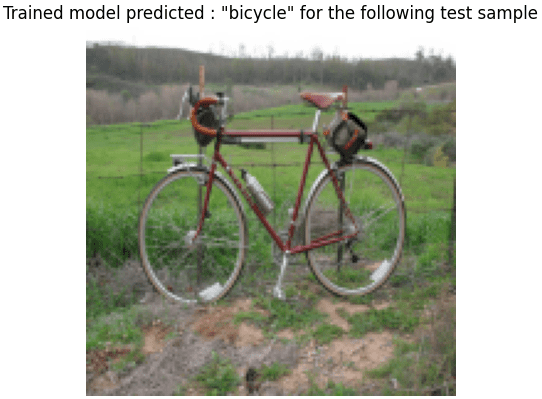

### **Prediction Performance Summary**  

The bar chart below illustrates the model's performance on the training data. While the model demonstrates a reasonable ability to detect objects in images, it struggles to identify all objects compared to the previous pre-trained model, resulting in a significant number of missed detections.  

On the positive side, the model effectively minimizes false detections, keeping the number of incorrectly classified objects relatively low.  

Since the model was trained on this data, its performance may not fully generalize to the test dataset.  


```pyhton
processed_df_train = process(train_df)

# Convert the processed data to tensors
pixel_values_train = tf.convert_to_tensor(processed_df_train['pixel_values'])

predictions = pre_trained_vit_model.predict(pixel_values_train)

# maximum prediction value for each image
max_predictions = predictions.max(axis=1)
max_predictions = max_predictions.reshape(-1, 1)

# thershold based off most confident prediction in that image
predictions_threshold = (predictions > max_predictions * 0.5).astype(int)

predictions_df = pd.DataFrame(predictions_threshold, columns=labels)
```

```python
preds = []
for pred_instace in predictions_df.iterrows():
    pred_classes = []
    for col_index, col_value in enumerate(pred_instace[1]):
        if col_value == 1:
            pred_classes.append(col_index)
    preds.append(pred_classes)

y_true = []
for outcome in y_train:
    classes = []
    for col_index, col_value in enumerate(outcome):
        if col_value == 1:
            classes.append(col_index)
    y_true.append(classes)
    
flat_preds = []
flat_true = []
all_missed = []
all_to_much = []
# classes_pred and classes_true are sorted
for classes_pred, classes_true in zip(preds, y_true):
        # Convert lists to sets for set operations
        set_search = set(classes_true)
        set_found = set(classes_pred)

        # Elements in array_search but not in array_found
        missed = list(set_search - set_found)

        # Elements in array_found but not in array_search
        to_much = list(set_found - set_search)

        # Elements in both array_search and array_found
        overlapping = list(set_search & set_found)

        # Print results
        all_missed = all_missed + missed
        all_to_much = all_to_much + to_much
        for i in overlapping:
            flat_preds.append(i)
            flat_true.append(i)
```

```python
occurrences_correct = count_occurrences(to_class_name(flat_preds))

occurrences_missed = match_keys(occurrences_correct, count_occurrences(to_class_name(all_missed)))

occurrences_to_much = match_keys(occurrences_correct, count_occurrences(to_class_name(all_to_much)))

print("Amount of correctly detected objects")
print(occurrences_correct)
print()
print("True labels that were not predicted")
print(occurrences_missed)
print()
print("Predicted classes that are not in images ")
print(occurrences_to_much)
```

> Amount of correctly detected objects
> {'cow': 28, 'bottle': 26, 'cat': 42, 'motorbike': 39, 'person': 108, 'horse': 35, 'train': 40, 'pottedplant': 19, 'aeroplane': 46, 'tvmonitor': 35, 'bicycle': 26, 'car': 36, 'boat': 46, 'chair': 20, 'bird': 51, 'bus': 34, 'sofa': 35, 'sheep': 26, 'dog': 32, 'diningtable': 32}
> 
> True labels that were not predicted
> {'person': 99, 'chair': 49, 'tvmonitor': 16, 'motorbike': 8, 'sofa': 9, 'bottle': 16, 'bus': 4, 'car': 27, 'pottedplant': 24, 'bird': 4, 'dog': 11, 'bicycle': 13, 'diningtable': 16, 'boat': 2, 'horse': 7, 'cat': 3, 'cow': 2, 'aeroplane': 1, 'sheep': 1, 'train': 0}
> 
> Predicted classes that are not in images 
> {'sofa': 12, 'chair': 3, 'person': 9, 'bottle': 2, 'horse': 1, 'pottedplant': 2, 'cat': 1, 'motorbike': 1, 'tvmonitor': 1, 'diningtable': 1, 'bus': 1, 'car': 2, 'boat': 2, 'cow': 1, 'train': 0, 'aeroplane': 0, 'bicycle': 0, 'bird': 0, 'sheep': 0, 'dog': 0}

```python
# importing package
import matplotlib.pyplot as plt


sorted_correct = dict(sorted(occurrences_correct.items(),key=lambda x:x[0]))
sorted_missed = dict(sorted(occurrences_missed.items(),key=lambda x:x[0]))
sorted_to_much = dict(sorted(occurrences_to_much.items(),key=lambda x:x[0]))


# create data
x = list(sorted_correct.keys())
correct = np.array(list(sorted_correct.values()))
missed = np.array(list(sorted_missed.values()))
to_much = np.array(list(sorted_to_much.values()))
 
fig, ax = plt.subplots()

# plot bars in stack manner
ax.bar(x, correct, color='g')
ax.bar(x, missed, bottom=correct, color='r')
ax.bar(x, to_much, bottom=correct + missed, color='b')

ax.set_xlabel('Classes')
ax.set_ylabel('Amount')
ax.set_title('Performance chart')
ax.tick_params(axis='x', rotation=75)

colors = {'Correct':'green', 'Missed':'red', 'To much' : 'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

plt.show()
```

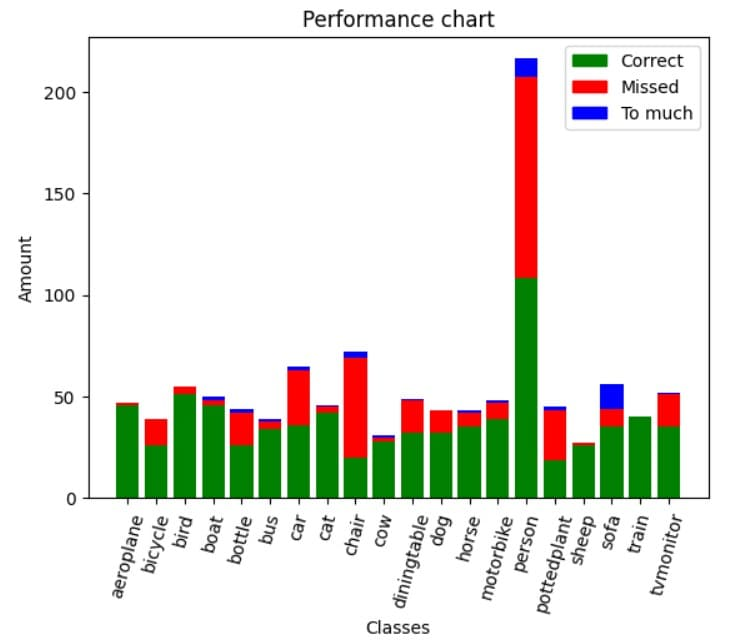

# 2.3 Conclusion: Classification

This section explored different architectures for building multi-label classification models.  

The models trained from scratch demonstrated various ways to construct CNN and ViT architectures layer by layer. However, training these models effectively was limited by insufficient training data, leading to overfitting.  

This challenge was addressed using pre-trained models, which have already been trained on large datasets and can be adapted to new tasks. The DETR and ViT architectures were examined, with the ViT model illustrating how pre-trained models can be extended by fine-tuning additional layers. These models achieved significantly better performance.  

Various methods were also used to track model performance. Training on a validation set provided insight into how accuracy improved with each epoch, while visualizations and plots helped illustrate both the training process and model predictions.  


# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Using the training set to train the CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

Image segmentation is a computer vision task that segments an image into multiple areas by assigning a label to every pixel of the image. It provides much more information about an image than object detection, which draws a bounding box around the detected object, or image classification, which assigns a label to the object.

Segmentation is useful and can be used in real-world applications such as medical imaging, clothes segmentation, flooding maps, self-driving cars, etc.

There are two types of image segmentation:

- Semantic segmentation: classify each pixel with a label.
- Instance segmentation: classify each pixel and differentiate each object instance.

### Model from scratch (U-Net)

The u-net is convolutional network architecture for fast and precise segmentation of images. U-Net is a semantic segmentation technique originally proposed for (bio)medical imaging segmentation. It’s one of the earlier deep learning segmentation models, and the U-Net architecture is also used in many GAN variants.The network is based on a fully convolutional neural network whose architecture was modified and extended to work with fewer training images and to yield more precise segmentation.

The model architecture is fairly simple: an encoder (for downsampling) and a decoder (for upsampling) with skip connections.

U-Net is a type of neural network that’s designed like a “U” shape (hence the name U-Net). It’s made up of two parts: a contracting part and an expanding part.

The contracting part is just like a normal neural network. It takes in an input and reduces it down, layer by layer, into a condensed form.

The expanding part then takes this condensed form and builds it back up, layer by layer, into an output that’s the same size as the original input.

Instead of reducing the size of the layers (like in the contracting part), the expanding part increases the size of the layers. It does this using something called upsampling, which is the opposite of pooling.

One special thing about U-Net is that it has lots of feature channels in the expanding part. This lets it carry detailed context information from the contracting part to the expanding part.

U-Net only uses the valid part of each convolution, and it doesn’t have any fully connected layers. This means it can work with images of any size.

To handle the edges of the image (where some context is missing), U-Net just mirrors the input image. This lets it work with large images without being limited by the memory of the GPU.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="500"/>

The gray arrows indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training.


References: 

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as t
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

Augment the images by flipping them horizontally.


In [ ]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

 A function to normalize the dataset by scaling the images to the range of [0, 1].

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image, input_mask

Two functions to preprocess the training and test datasets with a slight difference between the two – only perform image augmentation on the training dataset.

In [ ]:
def load_image_train(img, seg):
    input_image = img
    input_mask = seg
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(img, seg):
    input_image = img
    input_mask = seg
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

Resize the images and masks. function for resizing.

In [ ]:
def resize_images(images, img_size):
    list_images = list()

    height, width = img_size
    resize_layer = keras.layers.Resizing(height, width)
    for img in images:
        img_resized = resize_layer(img)
        list_images.append(img_resized)
    return np.array(list_images)

An input pipeline was constructed using `tf.data` with the `map()` function.  

- Images were resized to a shape of **128×128×3**, while the corresponding segmentation masks were resized to **128×128×1**.  
- Segmentation masks were converted into categorical data using one-hot encoding.  
- The training set was then split, reserving a portion for validation.  


In [ ]:
INPUT_HEIGHT = 128
INPUT_WIDTH = 128

trainImg = resize_images(train_df["img"], (INPUT_HEIGHT, INPUT_WIDTH))
trainImg = trainImg.astype(np.float16)


trainSeg = resize_images(train_df["seg"].apply(lambda x: np.expand_dims(x, axis=-1)), (INPUT_HEIGHT, INPUT_WIDTH))
trainSeg = trainSeg.astype(np.float16)
trainSeg = to_categorical(trainSeg, num_classes=21)

train_img_seg = tf.data.Dataset.from_tensor_slices((trainImg, trainSeg))
train_dataset, valid_dataset = keras.utils.split_dataset(train_img_seg, left_size=0.8)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)


testImg = resize_images(test_df["img"], (INPUT_HEIGHT, INPUT_WIDTH))
testImg = testImg.astype(np.float16)

testSeg = resize_images(test_df["seg"].apply(lambda x: np.expand_dims(x, axis=-1)), (INPUT_HEIGHT, INPUT_WIDTH))
testSeg = testSeg.astype(np.float16)
testSeg = to_categorical(testSeg, num_classes=21)


test_img_seg = tf.data.Dataset.from_tensor_slices((testImg, testSeg))
test_dataset = test_img_seg.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

Creating a batch size of 16 and a buffer size of 1000 for creating batches of training and test datasets. 

The train_batches and the validation_batches will be used for training the U-Net model. The test_batches can be used to evaluate the performance of the U-Net model after training.

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
#train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_batches = valid_dataset.batch(BATCH_SIZE)

test_batches = test_dataset.batch(BATCH_SIZE)

Visualizing a random sample image and its mask from the training dataset, to get an idea of how the data looks.
This is a random given image with its corresponding given segmentation mask.

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i != 0:  # if it's a mask
            display_list[i] = np.argmax(display_list[i], axis=-1).astype(np.float32)
        else:
            display_list[i] = tf.keras.utils.array_to_img(display_list[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

print("sample_image shape:", sample_image.shape)
print("sample_mask shape:", sample_mask.shape)
print("Unique values in sample_image:", np.unique(sample_image))
print("Unique values in sample_mask:", np.unique(sample_mask))
sample_image = sample_image
display([sample_image, sample_mask])




#### Model Architecture

Let’s define the U-Net model architecture. The U-Net is shaped like a letter U with an encoder, decoder, and the skip connections between them. A few building blocks to make the U-Net model will be created.

##### Building blocks:
-----------------------

**double_conv_block**: This function is a building block of the U-Net model. It consists of two sets of Conv2D and ReLU activation layers. Conv2D is a 2D convolution layer that creates a convolution kernel to produce a tensor of outputs. ReLU (Rectified Linear Unit) is an activation function that outputs the input directly if it’s positive; otherwise, it outputs zero.

**downsample_block**: This function is used in the encoder part of the U-Net. It first applies the double_conv_block to the input, then uses MaxPool2D for downsampling, and finally applies a Dropout layer. MaxPool2D is used to reduce the spatial dimensions (height and width) of the input volume. Dropout is a regularization technique that prevents overfitting by randomly setting a fraction of input units to 0 during training.

**upsample_block**: This function is used in the decoder part of the U-Net. It first upsamples the input using Conv2DTranspose (also known as deconvolution), then concatenates the upsampled input with features from the corresponding level in the encoder, applies a Dropout layer, and finally applies the double_conv_block. The concatenation of the upsampled input and the encoder features is a distinctive feature of U-Net and is known as skip-connection or shortcut connection. This helps the model to localize better and produce more precise segmentation.

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

##### U-Net Model:
-----------------------

**Inputs**: The model takes an input image of shape (128, 128, 3), which means the image is 128 pixels high, 128 pixels wide, and has 3 color channels (RGB).

**Encoder**: The encoder part of the model consists of four downsampling blocks. The number of filters in the convolutional layers increases with each block (64, 128, 256, and 512), allowing the model to learn more complex features.

**Bottleneck**: The bottleneck is the deepest layer in the network, where the spatial dimensions are the smallest. This layer uses 1024 filters.

**Decoder**: The decoder part of the model consists of four upsampling blocks. The number of filters in the convolutional layers decreases with each block (512, 256, 128, and 64), gradually merging the high-level features learned by the network with the more detailed information preserved in the skip-connections.

**Outputs**: Finally, a convolutional layer with a softmax activation function is used to generate the output. This layer has 21 filters, so it will output an image where each pixel belongs to one of 21 classes.

**Model Creation**: The U-Net model is created using the Keras Functional API, with the specified inputs and outputs.

In [ ]:
def build_unet_model(): # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(21, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

**Compile and Train U-Net**

-----------------------

To compile unet_model, specify the optimizer, the loss function, and the accuracy metrics to track during training:


The initial approach involved using the **sparse_categorical_crossentropy** loss function, which is commonly applied in multi-class classification problems. This function is suitable when classes are mutually exclusive, meaning each data point belongs to exactly one class. It calculates the difference between the model’s predictions and the actual values in the training data.  

One advantage of this loss function is its ability to handle integer labels for classes, making it more memory-efficient, particularly in datasets with a large number of classes.  

In early experiments with the U-Net model for image segmentation, sparse_categorical_crossentropy was used. However, this approach did not yield satisfactory results, as the model consistently predicted the background class for most pixels.  

This issue stemmed from **class imbalance** in the training data, where the majority of pixels belonged to the background class. As a result, the model favored predicting the background to minimize the loss, a common challenge in machine learning.  

To address this, alternative strategies are being explored, such as using different loss functions, applying class weighting, or oversampling the minority class. These techniques aim to improve the model’s ability to learn from underrepresented classes and enhance overall segmentation performance.  


In [ ]:
'''unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])'''

The **weighted categorical cross-entropy** loss function yielded the best results for addressing class imbalance.  

This approach involves assigning different weights to classes based on their frequency in the training data. Underrepresented classes (such as the non-background classes in this case) are given higher weights, while overrepresented classes (like the background) are assigned lower weights. This encourages the model to focus more on learning the underrepresented classes.  

Class weights were calculated by taking the inverse of their frequency in the training data. To further reduce the influence of the background class, its weight was multiplied by 10, as it was heavily overrepresented.  

A custom loss function, **weighted_categorical_crossentropy**, was then defined to incorporate these class weights into the standard categorical cross-entropy. This custom loss function penalizes the model more for errors on underrepresented classes, helping it to better learn these classes.  

The U-Net model was compiled using this custom loss function, along with the Adam optimizer and accuracy as the evaluation metric. After training with this setup, a significant improvement in model performance was observed. The model was able to segment the images more accurately, identifying not only the background but also the previously overlooked classes.  


In [ ]:
class_weights = {}
total_count = train_df["seg"].apply(lambda row: row.shape[0] * row.shape[1]).sum()
for i in range(21):
    count = train_df["seg"].apply(lambda row: np.count_nonzero(row == i)).sum()
    class_weights[i] = 1 / (count / total_count)
class_weights[0] *= 10
class_weights

def weighted_categorical_crossentropy(weights):    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

loss_function = weighted_categorical_crossentropy([class_weights[i] for i in class_weights])

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=loss_function,
                  metrics=['accuracy'])

Also experimented with other loss functions like:

**Dice Loss**: This function measures the overlap between the predicted and true segmentation masks. It’s particularly useful for handling imbalanced datasets.

**Focal Tversky Loss**: This is a modification of the Tversky index, a similarity measure for sets, with a focal term added to handle class imbalance. It’s often used in semantic segmentation tasks.

**Categorical Focal Loss**: This is a variant of the standard cross-entropy loss, with a modulating factor added to down-weight easy examples and focus on hard negatives. It’s useful when dealing with multi-class imbalance.

In [ ]:
'''def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - (numerator + 1) / (denominator + 1)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=dice_loss,
                   metrics=['accuracy'])'''

# ----------------------

'''def tversky(y_true, y_pred, smooth=1e-6):
    # Ensure the shapes match
    if y_true.shape != y_pred.shape:
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=focal_tversky_loss,
                   metrics=['accuracy'])'''

# ----------------------

'''
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a loss.
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return tf.keras.backend.mean(loss, axis=1)

    return categorical_focal_loss_fixed

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=[categorical_focal_loss(alpha=.25, gamma=2)],
                  metrics=['accuracy'])
'''

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = len(train_dataset)
print(TRAIN_LENGTH)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(STEPS_PER_EPOCH)

VAL_SUBSPLITS = 1
TEST_LENTH = len(valid_dataset)
print(TEST_LENTH)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
print(VALIDATION_STEPS)

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches)

**Prediction**

To see how the model perfoms a random image is selected from the validation dataset and the predicted segmentation mask is plotted.

The U-Net model, built from scratch, generally performs decently on the task of image segmentation. It’s capable of identifying and classifying objects in images with a reasonable degree of accuracy on the training and validation set. However, it’s not perfect. There are instances where the model may not perform as well as expected. In some cases, it might fail to detect the presence of an object altogether. In other situations, it might incorrectly classify an object, attributing it to the wrong class. When it comes to the test set, the model’s performance doesn’t quite match up.

Despite these limitations, the U-Net model remains a valuable tool in the field of image segmentation, and with further tuning and optimization, its performance on the test set can be improved. These possible improvements will be explained in more detail on another model


In [ ]:
# sample_test_batch = next(iter(train_batches))
# random_index = np.random.choice(sample_test_batch[0].shape[0])
# sample_test_image, sample_test_mask = sample_test_batch[0][random_index], sample_test_batch[1][random_index]

# Take the first example from the dataset
first_example = next(iter(train_dataset.skip(9).take(1)))

# Extract the image and segmentation
first_image, first_seg = first_example
first_image_exp = np.expand_dims(first_image, axis=0)

pred_mask = unet_model.predict(first_image_exp)
pred_mask_squeezed = np.squeeze(pred_mask)

display([first_image, first_seg, pred_mask_squeezed])


The following code makes predictions on the validation set and converts them back to the desired format from the categorical format.


In [ ]:
valid_images = []
valid_seg = []

for img, seg in valid_dataset:
    valid_images.append(img)  
    valid_seg.append(seg)


valid_images_array = np.stack(valid_images)

valid_pred = unet_model.predict(valid_images_array)
valid_pred_argmax=np.argmax(valid_pred, axis=3)
valid_argmax=np.argmax(valid_seg, axis=3)

The Dice score is a metric used to evaluate the performance of a segmentation model. This will be explained in more detail below.

In [ ]:
size_of_validation_dataset = len(valid_dataset)


def dice_score(ground_truth_mask, pred_mask):
    intersection_amount_without_zeros = np.sum((ground_truth_mask == pred_mask) & (ground_truth_mask != 0) & (pred_mask != 0))
    score = (2 * intersection_amount_without_zeros) / (np.sum((ground_truth_mask != 0)) + np.sum((pred_mask != 0)))
    return score


score = np.mean([dice_score(valid_argmax[i], valid_pred_argmax[i]) for i in range(size_of_validation_dataset)])
print(f"Dice score is {score}")

This code is designed for bulk resizing of images. It employs a Nearest Neighbors interpolation method during resizing, which is crucial for maintaining the integrity of the masks. Using this method is particularly important for masks because it preserves the original labels without introducing smoothing, which is undesirable for maintaining label accuracy.

In [ ]:
def resize_images_near(images,img_size):
    list_images = list()
    for img in images:
        img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_NEAREST)
        list_images.append(img_resized)
    return np.array(list_images)

Prediction are now given in the choosen image size of the input, following codes resizes these predictions to the same size of the corresponding image.

In [ ]:

validation_predictions = np.empty(size_of_validation_dataset, dtype=object)
for i, image in enumerate(train_df["img"][-size_of_validation_dataset:]):
    validation_predictions[i] = resize_images_near([valid_pred_argmax[i]], (image.shape[1], image.shape[0]))[0].astype(np.uint8)

validation_predictions.shape

In [ ]:
score = np.mean([dice_score(train_df.at[len(train_df)-size_of_validation_dataset+i, "seg"], validation_predictions[i]) for i in range(size_of_validation_dataset)])
print(f"Dice score is {score}")

## Manual FCN

A manual **Fully Convolutional Network (FCN)** was constructed following [these guidelines](https://keras.io/examples/vision/fully_convolutional_network/). However, the models tested did not result in significant improvements for the given use case.  

Further exploration of the FCN model is presented in the next section, where a library is used to build the model. As a result, this section was removed from the notebook for clarity.  


## Segmentation models

To compare different model architectures for segmentation, the **"segmentation-models"** library (https://github.com/qubvel/segmentation_models) was used. This library provides several models for testing, including:

- Unet  
- FPN  
- Linknet  
- PSPNet  

The library offers extensive customization options, such as the ability to select different backbones for the models and fine-tune the usual training parameters.  


In [ ]:
!pip install segmentation-models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from segmentation_models.metrics import IOUScore, FScore
from segmentation_models.losses import DiceLoss
from tensorflow.keras import backend as K

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import random
import cv2

The Dice score is a metric used to evaluate the performance of a segmentation model. The formula is as follows:

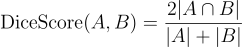

In code, the number of similar labels (excluding zero labels, which represent the background) is counted. This count is then multiplied by 2 and divided by the total count of non-zero labels in both the prediction and the ground truth of the segmentation. The resulting value is called the Dice score.

In [ ]:
def dice_score(ground_truth_mask, pred_mask):
    intersection_amount_without_zeros = np.sum((ground_truth_mask == pred_mask) & (ground_truth_mask != 0) & (pred_mask != 0))
    score = (2 * intersection_amount_without_zeros) / (np.sum((ground_truth_mask != 0)) + np.sum((pred_mask != 0)))
    return score

This use case involves 20 labels for possible objects in images for semantic segmentation. Including the background, this results in a total of 21 labels/classes. To evaluate the models, the training data is split into a portion used exclusively for training and the remainder used for validation. The segmentation models require consistent input dimensions, so an input height and input width are set during initialization.

In [ ]:
NUM_CLASSES = 21
VALIDATION_SIZE = 100

INPUT_HEIGHT = 144
INPUT_WIDTH = 144

The following function is a method to showcase the segmentation mask of an image. It assigns a unique color to each label, ensuring that the visualization of the masks is consistent.

In [ ]:
COLORS = np.random.randint(0, 255, size=(NUM_CLASSES-1, 3),dtype="uint8")
COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

def plot_mask(mask):

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            colored_mask[i][j] = COLORS[mask[i][j]]

    plt.imshow(colored_mask.astype(np.uint8))     

When training the model, it is likely to be biased towards predicting the background because most of the image is background. The following code calculates class weights to help solve this bias. These weights can then be used in the loss function to mitigate the problem. The weight for the background is multiplied by 10 to prevent it from being extremely low, which would otherwise result in much longer training times. After this adjustment, the weight for the background is still lower than the weights for other classes.

In [ ]:
class_weights = {}
total_count = train_df["seg"].apply(lambda row: row.shape[0] * row.shape[1]).sum()
for i in range(NUM_CLASSES):
    count = train_df["seg"].apply(lambda row: np.count_nonzero(row == i)).sum()
    class_weights[i] = 1 / (count / total_count)
class_weights[0] *= 10
class_weights

This code is designed for bulk resizing of images. It employs a Nearest Neighbors interpolation method during resizing, which is crucial for maintaining the integrity of the masks. Using this method is particularly important for masks because it preserves the original labels without introducing smoothing, which is undesirable for maintaining label accuracy.

In [ ]:
def resize_images(images,img_size):
    list_images = list()
    for img in images:
        img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_NEAREST)
        list_images.append(img_resized)
    return np.array(list_images)

The code resizes both the training images and labels. Additionally, the labels are converted into categorical data. This categorical conversion enhances the effectiveness of the semantic segmentation model by representing each label as a separate category.

In [ ]:
X_train = resize_images(train_df["img"], (INPUT_HEIGHT, INPUT_WIDTH))

y_train = resize_images(train_df["seg"], (INPUT_HEIGHT, INPUT_WIDTH))
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

The following code is a test to verify if the label values are maintained after resizing.

In [ ]:
index = 0
plt.hist(train_df.at[index, "seg"].flatten(), [i for i in range(21)])
plt.figure()
plt.hist(resize_images([y_train[index].argmax(-1)], train_df.at[index, "seg"].shape)[0].flatten(), [i for i in range(21)])
plt.show()

Also resize images and labels test set

In [ ]:
X_test = resize_images(test_df["img"], (INPUT_HEIGHT, INPUT_WIDTH))

y_test = resize_images(test_df["seg"], (INPUT_HEIGHT, INPUT_WIDTH))
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

Split data into training and validation sets

In [ ]:
X_valid = X_train[-VALIDATION_SIZE:]
X_train = X_train[:-VALIDATION_SIZE]

y_valid = y_train[-VALIDATION_SIZE:]
y_train = y_train[:-VALIDATION_SIZE]

The code selects the backbone architecture for the model and then pre-processes the input images for training, validation, and testing. These preprocessing steps are tailored to the chosen backbone architecture, ensuring compatibility and maximizing performance when integrated into the segmentation model.

In [ ]:
BACKBONE = 'senet154'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train_prepr = preprocess_input(X_train)
X_valid_prepr = preprocess_input(X_valid)
X_test_prepr = preprocess_input(X_test)

Metrics are initialized for use during training, including IOU Score and F-Score. Additionally, a loss function is defined to consider class weights. This function computes the weighted categorical cross-entropy loss, where the weights are applied to each class to address class imbalance.

In [ ]:
metric1 = IOUScore()
metric2 = FScore()

def weighted_categorical_crossentropy(weights):    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

loss_function = weighted_categorical_crossentropy([class_weights[i] for i in class_weights])

### Example model training

This code snippet, used for training, is provided in markdown format. It couldn't be executed in the Kaggle environment due to RAM limitations. Instead, it was run locally on a computer to train the model, which was then saved to use in kaggle.

The model is initialized with the imagenet weights which should lead to faster convergence, better generalization and improved performance.

**Initializing model**

```python
model = sm.PSPNet(
    BACKBONE, 
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, 3), 
    encoder_weights='imagenet',
    # encoder_freeze=True,
    classes=NUM_CLASSES,
    activation='softmax')

model.compile(optimizer='adam', loss=loss_function, metrics=metrics)

model.summary()
```

**Training model**

```python
history = model.fit(X_train_prepr,
          y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          validation_data=(X_valid_prepr, y_valid))
```

**Visualization evolution accuracy**

```python
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
```

**Store model**
```python
model.save('models/pspnet_144_senet154_weighted.hdf5')
```

The following shows some test that were prefomed to select a good model/paramters:



$Parameters:$
It seems that the scores displayed are from an outdated metric where the Dice score was incorrectly implemented, including the background labels. Due to the lengthy training process, the test was not rerun. However, while not completely accurate, these scores can still provide some indication of whether the model has improved compared to previous iterations.

Score is 0.8103525735077401 of the default Unet model with parameters:
- batch_size = 16
- optimizer = "adam"
- loss = "categorical_crossentropy"
- backbone = "resnet23"

Different batch_size:
- batch_size 32 -> 0.8106076033437526

Different losses:
- JacardLoss -> 0.7736489077342782
- DiceLoss -> 0.2985855143416016
- CategoricalCELoss -> 0.8121003589093242
- CategoricalFocalLoss -> 0.8118274906110803

Different backbones:
- resnet101 -> 0.7864043769326835
- seresnet34 -> 0.8032464194278462
- seresnet101 -> 0.7946455987432236
- senet154 -> 0.8236003400319645

From this was concluded that following paramters would be used.
- batch_size = 16
- optimizer = "adam"
- loss = "CategoricalCELoss"
- backbone = "senet154"

$Model architectures:$
Here, various model architectures are compared using the Dice score, with the correct implementation of the metric. Additionally, different input sizes are tested to evaluate their impact on performance. Resnet34 is used as backbone for these tests.

(model input_size)
- FPN 128 -> 0.06303106749221483
- FPN 160 -> 0.07985550085840774

- Unet 128 -> 0.08788949658979335
- Unet 160 -> 0.07933247285693656

- Linknet 128 -> 0.06549286697881271
- Linknet 160 -> 0.08647424310709693

- PSPNet 144 -> 0.09058090617129505

From these tests the PSPNet archictectured performed the best, this is the model that was used in the rest of this notebook.
The code below is the model trained by the example code shown above.

Loading locally trained model in keras

In [ ]:
model = load_model('/kaggle/input/pspnet/keras/144-senet154/1/pspnet_144_senet154_backbone.hdf5') # loading model...

The loaded model is a PSPNet (Pyramid Scene Parsing Network), a semantic segmentation model that employs a pyramid parsing module to leverage global context information through different-region based context aggregation. This combination of local and global clues enhances the reliability of the final prediction.

Given an input image of size (144, 144), PSPNet uses a pretrained CNN (senet154) with a dilated network strategy to extract the feature map. The resulting feature map retains the dimensions of the input image. A pyramid pooling module is then applied on top of this map to gather context information. This prior is concatenated with the original feature map in the final stage, followed by a convolution layer to generate the final prediction map.

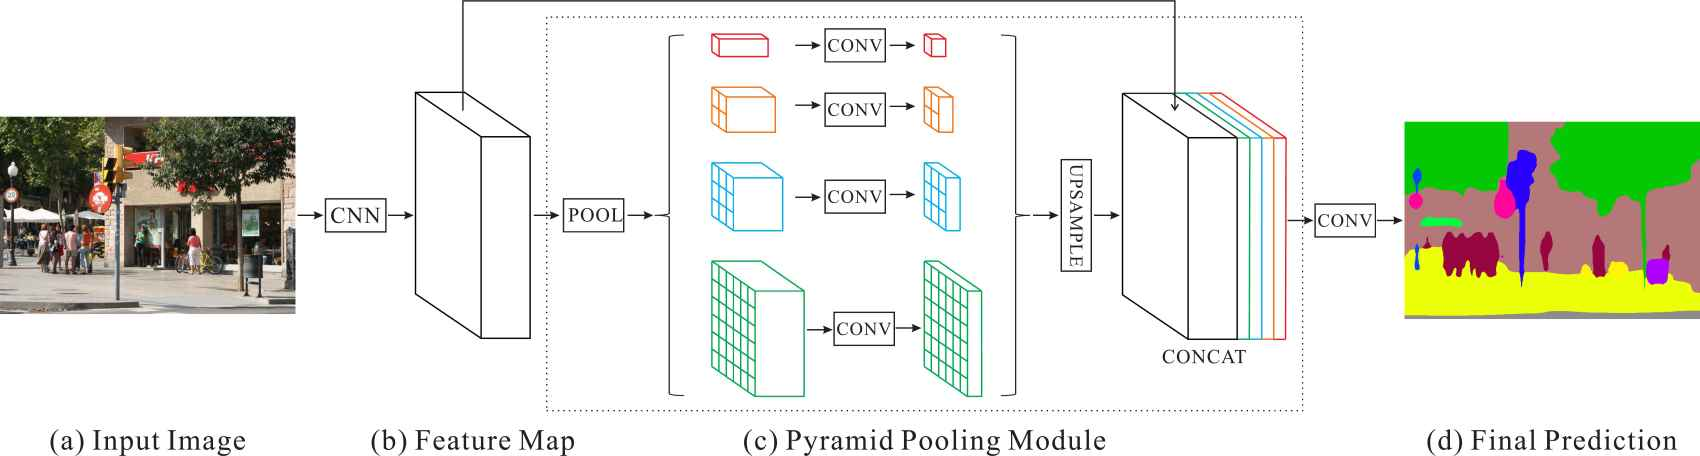

The following code uses the model to make predictions on the validation set and converts them back to the desired format from the categorical format.

In [ ]:
y_pred=model.predict(X_valid_prepr)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_valid_argmax=np.argmax(y_valid, axis=3)

Dice score calculated on the raw predictions from the model:

In [ ]:
score = np.mean([dice_score(y_valid_argmax[i], y_pred_argmax[i]) for i in range(VALIDATION_SIZE)])
print(f"Dice score is {score}")

To see how the model perfoms a random image is selected from the validation dataset and the predicted segmentation mask is plotted.

In [ ]:
img_number = 0
img = X_valid[img_number]
ground_truth = y_valid_argmax[img_number]

img_input = X_valid_prepr[img_number]
img_input=np.expand_dims(img_input, 0)
prediction = (model.predict(img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.title('Testing Image')
plt.imshow(img/255)
plt.show()

print('Testing Label')
plot_mask(ground_truth)

print('Prediction on test image')
plot_mask(predicted_img)

Prediction are now given in the choosen image size of the input, following codes resizes these predictions to the same size of the corresponding image.

In [ ]:
validation_predictions = np.empty(VALIDATION_SIZE, dtype=object)
for i, image in enumerate(train_df["img"][-VALIDATION_SIZE:]):
    validation_predictions[i] = resize_images([y_pred_argmax[i]], (image.shape[1], image.shape[0]))[0].astype(np.uint8)

validation_predictions.shape

Dice score after resizing:

In [ ]:
score = np.mean([dice_score(train_df.at[len(train_df)-VALIDATION_SIZE+i, "seg"], validation_predictions[i]) for i in range(VALIDATION_SIZE)])
print(f"Dice score is {score}")

By making a cofunsion matrix that visualised the predictions made for segmentation compared to the true labels gives a good insight in how the model performs. From the matrix can be observed that the model is good in predicting the labels for an airplane but isn't able to correctly label a chair.

In [ ]:
true_labels = np.array([value for row in train_df["seg"].tail(VALIDATION_SIZE) for value in row.flatten()])
predicted_labels = np.array([value for row in validation_predictions for value in row.flatten()])

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

segmentation_labels = ["background"]
segmentation_labels.extend(train_df.columns[:-2])

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels, normalize="pred")
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=segmentation_labels, columns=segmentation_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=segmentation_labels, yticklabels=segmentation_labels, annot_kws={"size": 10})

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In some cases, the predicted masks may contain incorrect sections from labels of objects that are not present in the image. To address this issue, ground truth classifications are utilized to replace these labels. This replacement involves assigning either the label of the background or the label of a neighboring section that corresponds to an object in the image. For testing purposes, the ground truth predictions are used. However, in practice, these labels would typically be predicted by another model before being utilized. Following code implements an algorithm to achieve this goal.

In [ ]:
def get_neighbors(row, col, matrix):
    # Get the dimensions of the matrix
    rows, cols = matrix.shape

    # Define the relative positions of the neighbors
    neighbors_offsets = [(-1, -1), (-1, 0), (-1, 1),
                         (0, -1),         (0, 1),
                         (1, -1), (1, 0), (1, 1)]
    
    neighbors = []
    
    for dr, dc in neighbors_offsets:
        r, c = row + dr, col + dc
        if 0 <= r < rows and 0 <= c < cols:
            neighbors.append(matrix[r, c])
    
    return neighbors
    
def correct_segmentation_mask(predicted_mask, predicted_labels):
    corrected_mask = predicted_mask.copy().astype(int)
    invalid_mask = ~np.isin(corrected_mask, np.concatenate((predicted_labels, [0])))
    corrected_mask[invalid_mask] = -1

    changes = 1
    while changes != 0:
        changes = 0
        coords = np.argwhere(corrected_mask == -1)
        np.random.shuffle(coords)  # Shuffle to ensure random selection from valid neighbors
        
        for coord in coords:
            row, col = coord
            neighbors = get_neighbors(row, col, corrected_mask)
            valid_neighbors = [n for n in neighbors if n in predicted_labels]
            if valid_neighbors:
                corrected_mask[row, col] = random.choice(valid_neighbors)
                changes += 1

    corrected_mask[corrected_mask == -1] = 0

    return corrected_mask.astype(np.uint8)   

The following code blocks showcase this algorithm applied to a test image.

In [ ]:
val_index = 0
index = val_index - VALIDATION_SIZE + len(train_df)

In [ ]:
plot_mask(train_df.at[index, "seg"])

In [ ]:
plot_mask(validation_predictions[val_index])

In [ ]:
predicted_labels = np.where(train_df.loc[index][:NUM_CLASSES-1] == 1)[0] + 1

print(predicted_labels)

corrected_predicition = correct_segmentation_mask(validation_predictions[val_index], predicted_labels)

plot_mask(corrected_predicition)

Now this algorithm can be applied to all predictions of the validation set to improve the accuracy of the segmentation.

In [ ]:
corrected_validation_predictions = [] 
for i in range(VALIDATION_SIZE):
    predicted_labels = np.where(train_df.loc[i - VALIDATION_SIZE + len(train_df)][:NUM_CLASSES-1] == 1)[0] + 1
    corrected_prediction = correct_segmentation_mask(validation_predictions[i], predicted_labels)
    corrected_validation_predictions.append(corrected_prediction)

Dice score after filtering/changing labels of the segmentation predictions by utilizing the classification labels:

In [ ]:
score = np.mean([dice_score(train_df.at[len(train_df)-VALIDATION_SIZE+i, "seg"], corrected_validation_predictions[i]) for i in range(VALIDATION_SIZE)])
print(f"Dice score is {score}")

Comparing the confusion matrix with before can be observerd that a lott less missclassification are happening between the object labels.

In [ ]:
true_labels = np.array([value for row in train_df["seg"].tail(VALIDATION_SIZE) for value in row.flatten()])
predicted_labels = np.array([value for row in corrected_validation_predictions for value in row.flatten()])

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

segmentation_labels = ["background"]
segmentation_labels.extend(train_df.columns[:-2])

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels, normalize="pred")
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=segmentation_labels, columns=segmentation_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=segmentation_labels, yticklabels=segmentation_labels, annot_kws={"size": 10})

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

To further improve the model's results, several strategies can be employed:

1. **Weighted Loss Function**: Using a weighted loss function during training helps address the model's bias towards frequently occurring labels, such as the background. Implementing this approach has shown to improve the Dice score to 0.3756918497153965 on the validation set. Additionally, the Dice score further increases to 0.4993404081846432 after post-processing the labels with predictions from a multi-classification model.

2. **Larger Input Images**: Increasing the size of the input images allows the model to learn more detailed information from the images. However, this approach will require more epochs for training as it becomes more challenging to fine-tune the weights.

3. **Using the Full Training Set**: Training on the entire dataset without splitting it can also enhance the model's performance, as it leverages all available data for learning.

By implementing these strategies, the overall performance of the model can be further improved. But after adding the weighed loss function to the model it wasn't possible to load the model in kaggle anymore due to an error. This error didn't occur when loading the model on the local machine.

## DETECTRON panoptic segmentation

The next part implements a panoptic segmentation model developed by facebook called detectron2 (https://github.com/facebookresearch/detr?tab=readme-ov-file). Panoptic segmentation is a combination of semantic segmentation and instance segmentation. This method provides a comprehensive understanding of the scene by segmenting the image into semantically meaningful parts or regions, while also detecting and distinguishing individual instances of objects within those regions. The dectron model is trained with the COCO dataset which contains 250 different labels which all overlap with the 20 labels from the PASCAL VOC dataset.

In [ ]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

Downloading the detectron model from facebook and assigning the GPU to use for this model.

In [ ]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval();

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



The following list contains the labels from the COCO dataset as strings, positioned such that each index corresponds to the same label in the PASCAL VOC dataset. This array is used to convert the labels between these two representations.

In [ ]:
CLASSES = [
    'N/A',
    'airplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'dining table',
    'dog',
    'horse',
    'motorcycle',
    'person',
    'potted plant',
    'sheep',
    'couch',
    'train',
    'tv'
]

The next code block contains a function that goes thruth each label of the predicted mask and converts is from the COCO format predicted by the detectron model to the desired format that corresponds to the PASCAL VOC dataset.


In [ ]:
from detectron2.data import MetadataCatalog
import numpy as np

meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")

def convert_categories(index):
  if index < len(result["segments_info"]):
    c = result["segments_info"][index]["category_id"]
    label = meta.thing_classes[meta.thing_dataset_id_to_contiguous_id[c]] if result["segments_info"][index]["isthing"] else meta.stuff_classes[meta.stuff_dataset_id_to_contiguous_id[c]]
    return CLASSES.index(label) if label in CLASSES else 0
  else:
    return 0

vectorized_convert_categories = np.vectorize(convert_categories)

Now that it's possible to convert between formats it's possible to make predictions on the validation set and convert these to the desired format.

In [ ]:
validation_predictions = np.empty(VALIDATION_SIZE, dtype=object)
for i in range(VALIDATION_SIZE):
  im = Image.fromarray(train_df.at[len(train_df)-VALIDATION_SIZE+i, "img"])

  img = transform(im).unsqueeze(0).to(device)
  out = model(img)

  result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
    
  mask = vectorized_convert_categories(panoptic_seg[:,:,0])
    
  validation_predictions[i] =  cv2.resize(mask.astype(np.uint8), im.size, interpolation=cv2.INTER_NEAREST)

  print(f"DETR segmentation progress (validation) {i+1}/{VALIDATION_SIZE}", end="\r")

Calculating the dice score from the predictions made by the detectron model on the validation set gives a very good score. 

In [ ]:
score = np.mean([dice_score(train_df.at[len(train_df)-VALIDATION_SIZE+i, "seg"], validation_predictions[i]) for i in range(VALIDATION_SIZE)])
print(f"Dice score is {score}")

From the confusion matrix can be observed that in general the model performance good, the model has the most difficulties for predicting the labels for chairs, bottles and bikes.

In [ ]:
true_labels = np.array([value for row in train_df["seg"].tail(VALIDATION_SIZE) for value in row.flatten()])
predicted_labels = np.array([value for row in validation_predictions for value in row.flatten()])

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

segmentation_labels = ["background"]
segmentation_labels.extend(train_df.columns[:-2])

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels, normalize="pred")
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=segmentation_labels, columns=segmentation_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=segmentation_labels, yticklabels=segmentation_labels, annot_kws={"size": 10})

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Now the same method can be applied to the test set to use for the submission.

In [ ]:
test_predictions = np.empty(len(test_df), dtype=object)
for i in range(len(test_df)):
  im = Image.fromarray(test_df.at[i, "img"])

  img = transform(im).unsqueeze(0).to(device)
  out = model(img)

  result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
    
  mask = vectorized_convert_categories(panoptic_seg[:,:,0])
    
  test_predictions[i] =  cv2.resize(mask.astype(np.uint8), im.size, interpolation=cv2.INTER_NEAREST)

  print(f"DETR segmentation progress (test) {i+1}/{len(test_df)}", end="\r")

In [ ]:
detr_predict_df["seg"] = test_predictions 

In [ ]:
detr_predict_df.head(5)

### **3.3 Conclusion Segmentation**

Semantic segmentation involves assigning a label to each pixel in an image, rather than just to the entire image. The goal is to accurately identify the locations of different objects within an image. In this section, a similar approach to image classification was taken to explore both from-scratch and pre-trained models.

The from-scratch model demonstrated how a segmentation network can be built layer by layer. A U-Net architecture was chosen for this purpose, as it is particularly well-suited for medical image segmentation tasks. Training this model using only the available data yielded better results than the from-scratch image classification models, but there were still noticeable limitations.

To improve results, pre-trained models were explored. Initially, a manual Fully Convolutional Network (FCN) was constructed, but its performance was lackluster, leading to its removal from further consideration. Next, a PSPNet model with a pre-trained backbone was tested. This model was run locally due to RAM limitations on Kaggle, and while some additional challenges were faced, potential solutions were proposed. Finally, a panoptic segmentation model based on the DETR architecture was explored. This model, which uses transformers for segmentation tasks, showed impressive performance and was ultimately used in the final submission.

The task of segmentation proved to be more complex than classification, introducing additional challenges. However, exploring various solutions and evaluating their effectiveness provided valuable insights into the complexity of these models.


## Submit to competition


In [ ]:
# test_df.loc[:, labels] = np.ones_like(test_df.loc[:, labels])

In [ ]:
labels = train_df.columns[:-2]

In [ ]:
plot_images(detr_predict_df, labels)

In [ ]:
#generate_submission(test_df)
#predictions_df['seg'] = np.empty(len(test_df), dtype=object)
#predictions_df["seg"] = test_predictions
# detr_predict_df['seg'] = -1
generate_submission(detr_predict_df)

# 4. Adversarial attack

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
from matplotlib import pyplot as plt

## Load the model
put the model in evaluation mode so that it does not update the gradients.

In [ ]:
model = resnet50(pretrained=True)
model.eval()

 ## Load ImageNet Class Labels


In [ ]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

##  Preprocess the Image


In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = preprocess(image).unsqueeze(0)
    return image

In [ ]:
def predict(image):
    output = model(image)
    _, predicted = torch.max(output, 1)
    percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
    _, indices = torch.sort(output, descending=True)
    return [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

## define loss function

nn.CrossEntropyLoss() is a common loss function for classification tasks that combines nn.LogSoftmax() and nn.NLLLoss() (negative log likelihood loss).

In [ ]:
criterion = nn.CrossEntropyLoss()

## FGSM Attack Function

The Fast Gradient Sign Method (FGSM) is a simple yet effective adversarial attack that targets neural networks. The attack is designed to be fast and requires minimal computational resources

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


fsgm works by using the gradient of the loss in relation to the input image to create a new image that maximizes the loss. The gradient is calculated with respect to the input image, and the sign of the gradient is used to create the new image. The epsilon parameter controls the magnitude of the perturbation.

let's break down the steps of the FGSM attack function:

1. Calculate the gradient of the loss with respect to the input image.
2. Compute the sign of the gradient to determine the direction of the perturbation.
3. Create a new image by adding the perturbation to the original image.
4. Clip the pixel values of the new image to ensure they are within the valid range of [0, 1].
5.  Return the perturbed image.


## Test the FGSM Attack Function

In [ ]:
image_path = "bike.jpeg"
image = preprocess_image(image_path)
image.requires_grad = True

## peliminary prediction


In [ ]:
# make a peliminary prediction
print("Prediction before attack:")
preditiction = predict(image)
#plot percentages of top 10 classes
plt.figure(figsize=(6,3))
plt.bar(*zip(*preditiction))
plt.xticks(rotation=90)
plt.show()

## fsgm attack

In [ ]:
epsilon = 0.03
output = model(image)   
loss = -criterion(output, torch.tensor([1]))  # 1 is the target class (goldfish)
model.zero_grad()
loss.backward()
data_grad = image.grad.data
perturbed_image = fgsm_attack(image, epsilon, data_grad)

## Prediction after attack


In [ ]:
plt.imshow(perturbed_image[0].permute(1, 2, 0).detach().numpy())
print("Prediction after attack:")
prediction = predict(perturbed_image)
plt.figure(figsize=(6,3))
plt.bar(*zip(*prediction))
plt.xticksa(rotation=90)

## PGD-Attack

The Projected Gradient Descent (PGD) attack is an iterative variant of the FGSM attack. It is considered to be more powerful than the FGSM attack, as it applies the FGSM attack multiple times with small step sizes. The PGD attack is designed to find the perturbation that maximizes the loss while staying within a certain epsilon value.


In [ ]:
def pgd_attack(image, epsilon, alpha, num_iter, target_class):
    perturbed_image = image.clone().detach()
    for _ in range(num_iter):
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        loss = -criterion(output, torch.tensor([target_class]))
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_image = perturbed_image + alpha * perturbed_image.grad.sign()
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon).detach()
    return perturbed_image


let's break down the steps of the PGD attack function:

1. Create a copy of the input image to store the perturbed image.
2. Iterate over a fixed number of iterations.
3. Enable gradient computation for the perturbed image.
4. Compute the output of the model and calculate the loss with respect to the target class.
5. Backpropagate the loss to compute the gradient of the perturbed image.
6. Update the perturbed image by adding a small step in the direction of the gradient.
7. Clip the pixel values of the perturbed image to ensure they are within the valid range of [0, 1].
8. Return the perturbed image.

## Test the PGD Attack Function


In [ ]:
image_path = "bike.jpeg"
image = preprocess_image(image_path)
image.requires_grad = True

# we use the same parameters as in the FGSM attack
epsilon = 0.03
# alpha is the step size for the PGD attack
alpha = 0.01
# number of iterations for the PGD attack
num_iter = 40



## Preliminary Prediction


In [ ]:
print("Prediction before attack:")
prediction = predict(image)
plt.figure(figsize=(6,3))
plt.bar(*zip(*prediction))
plt.xticks(rotation=90)
plt.show()

## PGD Attack


In [ ]:
perturbed_image = pgd_attack(image, epsilon, alpha, num_iter, 1)


## Prediction after attack


In [ ]:
plt.imshow(perturbed_image[0].permute(1, 2, 0).detach().numpy())
print("Prediction after attack:")
prediction = predict(perturbed_image)
plt.figure(figsize=(6,3))
plt.bar(*zip(*prediction))
plt.xticks(rotation=90)

 the model is fooled by the attack and the target class is the top prediction.

## realworld attacks

### Tecchincal feasibility of this attack
#### Access to the model

The attacker needs access to the model to compute the gradients and perform the attack. This can be done by querying the model through an API or by downloading the model and running it locally. just having access to the model is not enough, the attacker also needs to know the architecture of the model and the class labels.

#### White-box vs Black-box Attacks
for a black-box attack, the attacker does not have access to the model and needs to query the model through an API. This makes the attack more challenging, as the attacker does not have access to the gradients and needs to rely on other methods such as transfer learning or model inversion.

### Practical Feasibility

### physical world attacks
a physical world attack is not feasible for this attack as the perturbation is sensitive to the input image and may not transfer well to the physical world. However, there are other attacks such as adversarial stickers or adversarial glasses that can be used to fool object detection systems in the physical world.

### Defenses

the defense for this attack is to use adversarial training, which involves training the model with adversarial examples to make it more robust to attacks. Other defenses include input preprocessing, gradient masking, and adversarial training with randomization. 




# 5. Discussion

In this project, three major challenges in computer vision were explored: image classification, semantic segmentation, and adversarial attacks. Each of these areas presented unique challenges and solutions, and provided insights into the complexities of real-world computer vision tasks.

### **Multiclass Classification**

Multiclass classification goes beyond traditional classification problems, as it involves predicting multiple labels that may appear in each image. This increases the complexity of the task. Several approaches to solving this challenge were explored, with a focus on both from-scratch and pre-trained models:

- **From-scratch Models:** These models allowed for the construction of a model layer by layer. Two different architectures were explored: Vision Transformer (ViT) and Convolutional Neural Networks (CNN). Both architectures used a softmax activation function in the output layer and binary cross-entropy loss for multiclass classification. However, both models struggled to generalize beyond the training data, likely due to the limited amount of data available for training.

- **Pre-trained Models:** These models have been trained on massive datasets and thus do not face the same limitations of data scarcity. The first strategy involved using models pre-trained on datasets with labels similar to those in the target dataset, which can be useful when the training data is scarce. The second strategy explored fine-tuning a pre-trained model by adding trainable layers on top to adapt the model to the specific task. Both strategies utilized the softmax activation function and binary cross-entropy loss. In the end, the pre-trained models outperformed the from-scratch models, demonstrating the significant advantage of leveraging large pre-trained networks.

In conclusion, different models and approaches exist, each with its own strengths and weaknesses. Pre-trained models, in particular, proved to be the most effective for this task.

### **Semantic Segmentation**

Semantic segmentation involves not only labeling entire images but also determining where in the image each object is located. This task is more complex than classification, and we explored both from-scratch and pre-trained models to solve this challenge:

- **From-scratch Model (U-Net):** A U-Net architecture was explored as a convolutional network designed specifically for image segmentation. The model was constructed layer by layer and used softmax activation with categorical cross-entropy loss. Despite being limited by the lack of large training data, this model performed better than the from-scratch image classification models. To improve its performance, a custom-weighted categorical cross-entropy loss function was introduced to address the class imbalance problem.

- **Pre-trained Models:** Several pre-trained models were tested. The first was PSPNet, which uses a pre-trained CNN backbone for feature extraction. Although this model was trained on our dataset, it showed some issues, including misclassifying objects that weren't present in the image. A solution was proposed to refine these predictions by assigning misclassifications either to the background or the correct label. Additionally, a panoptic segmentation model, similar to the DETR used in classification, was explored. This model showed impressive results and was used for the final submission.

In summary, the exploration of different architectures for segmentation provided valuable lessons on improving model performance, particularly in dealing with class imbalance and refining misclassifications. As with classification, pre-trained models were more successful than from-scratch models.

### **Adversarial Attacks**

Adversarial attacks are techniques used to deceive models into making incorrect predictions. These attacks can be classified into two major categories:

- **White-box Attacks:** In this scenario, the attacker has full access to the targeted model's architecture and parameters, making it easier to craft effective attacks. 
    - **FGSM (Fast Gradient Sign Method):** This white-box attack introduces a perturbation to the image that maximizes the gradient of the loss with respect to the input image. The severity of the attack can be controlled using the epsilon value. The effectiveness of this attack was demonstrated by showing predictions before and after the attack, illustrating how the model was tricked.
    - **PGD-Attack (Projected Gradient Descent):** Another white-box attack, PGD applies the FGSM attack multiple times with small step sizes, staying within a defined epsilon value. Similar to FGSM, this attack was effective in causing misclassification, as demonstrated in the predictions before and after the attack.

- **Black-box Attacks:** Unlike white-box attacks, the attacker doesn't have access to the model’s inner workings and can only observe the model's outputs. This makes the attack more challenging to execute but still possible.

The attacks showcased in this project demonstrated how small, seemingly imperceptible changes to an image can result in drastic misclassifications. These examples highlighted the need for models to be robust against adversarial noise, as such attacks can easily undermine the reliability of computer vision systems.

### **Conclusion**

Through the exploration of image classification, semantic segmentation, and adversarial attacks, several key takeaways emerged. In classification and segmentation tasks, pre-trained models provided a significant advantage, outperforming from-scratch models due to their ability to leverage vast amounts of pre-existing data. In the case of adversarial attacks, the demonstrated white-box attacks showcased the vulnerability of machine learning models to small perturbations, emphasizing the importance of developing robust systems.

This project provided valuable insights into both the strengths and limitations of current computer vision techniques and will contribute to a deeper understanding of how these methods can be applied in real-world scenarios.
